In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils
import torch.utils.data
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from math import pi

In [2]:
# Define the exact solution
def exact_solution_u(x, t):
    return torch.sin(x)*torch.cos(t)

def initial_condition_u(x):
    return torch.sin(x)

def initial_condition_u_t(x):
    return 0.0*pi*torch.cos(x) 

In [3]:
# Define the exact solution
def exact_solution_p(x, t):
    return pi/2*torch.sin(x)*torch.cos(t)

def initial_condition_p(x):
    return pi/2*torch.sin(x)

def initial_condition_p_t(x):
    return 0*torch.sin(x) 

In [4]:
# assigning number of points
initial_pts = 2000
left_boundary_pts = 2000 
right_boundary_pts = 2000
residual_pts = 10000

In [5]:
# Type of optimizer (ADAM or LBFGS)
opt_type = "LBFGS"

manualSeed = 1

#np.random.seed(manualSeed)
#random.seed(manualSeed)
torch.manual_seed(manualSeed)

x_init = pi*torch.rand((initial_pts,1)) # initial pts
t_init = 0*x_init
init =  torch.cat([x_init, t_init],1)
u_init = initial_condition_u(init[:,0]).reshape(-1, 1)
p_init = initial_condition_p(init[:,0]).reshape(-1, 1)
w_init = torch.cat([u_init, p_init],1)

u_t_init = initial_condition_u_t(init[:,0]).reshape(-1, 1)
p_t_init = initial_condition_p_t(init[:,0]).reshape(-1, 1)
w_t_init = torch.cat([u_t_init, p_t_init],1)



xb_left = torch.zeros((left_boundary_pts, 1)) # left spatial boundary
tb_left = torch.rand((left_boundary_pts, 1)) # 
b_left = torch.cat([xb_left, tb_left ],1)
u_b_l = exact_solution_u(xb_left, tb_left)
p_b_l = exact_solution_p(xb_left, tb_left)
w_b_l = torch.cat([u_b_l, p_b_l],1)



xb_right = pi*torch.ones((right_boundary_pts, 1)) # right spatial boundary
tb_right = torch.rand((right_boundary_pts, 1)) # right boundary pts
b_right = torch.cat([xb_right, tb_right ],1)
u_b_r = exact_solution_u(xb_right, tb_right)
p_b_r = exact_solution_p(xb_right, tb_right)
w_b_r = torch.cat([u_b_r, p_b_r],1)

x_interior = pi*torch.rand((residual_pts, 1))
t_interior = torch.rand((residual_pts, 1))
interior = torch.cat([x_interior, t_interior],1)





training_set = DataLoader(torch.utils.data.TensorDataset(init, w_init, w_t_init, b_left,  b_right), batch_size=2000, shuffle=False)

In [6]:
class NeuralNet(nn.Module):

    def __init__(self, input_dimension, output_dimension, n_hidden_layers, neurons):
        super(NeuralNet, self).__init__()
        # Number of input dimensions n
        self.input_dimension = input_dimension
        # Number of output dimensions m
        self.output_dimension = output_dimension
        # Number of neurons per layer 
        self.neurons = neurons
        # Number of hidden layers 
        self.n_hidden_layers = n_hidden_layers
        # Activation function 
        self.activation = nn.Tanh()
        
        self.input_layer = nn.Linear(self.input_dimension, self.neurons)
        self.hidden_layers = nn.ModuleList([nn.Linear(self.neurons, self.neurons) for _ in range(n_hidden_layers)])
        self.output_layer = nn.Linear(self.neurons, self.output_dimension)

    def forward(self, x):
        # The forward function performs the set of affine and non-linear transformations defining the network 
        # (see equation above)
        x = self.activation(self.input_layer(x))
        for k, l in enumerate(self.hidden_layers):
            x = self.activation(l(x))
        return self.output_layer(x)


In [7]:
# Model definition
my_network = NeuralNet(input_dimension = init.shape[1], output_dimension = w_init.shape[1], n_hidden_layers=4, neurons=20)


In [8]:
def init_xavier(model, retrain_seed):
    torch.manual_seed(retrain_seed)
    def init_weights(m):
        if type(m) == nn.Linear and m.weight.requires_grad and m.bias.requires_grad:
            g = nn.init.calculate_gain('tanh')
            torch.nn.init.xavier_uniform_(m.weight, gain=g)
            #torch.nn.init.xavier_normal_(m.weight, gain=g)
            m.bias.data.fill_(0)
    model.apply(init_weights)

# Random Seed for weight initialization
retrain = 128
# Xavier weight initialization
init_xavier(my_network, retrain)
#print(my_network(init))

In [9]:
if opt_type == "ADAM":
    optimizer_ = optim.Adam(my_network.parameters(), lr=0.001)
elif opt_type == "LBFGS":
    optimizer_ = optim.LBFGS(my_network.parameters(), lr=0.1, max_iter=1, max_eval=50000, tolerance_change=1.0 * np.finfo(float).eps)
else:
    raise ValueError("Optimizer not recognized")

In [10]:
def fit(model, training_set, interior, num_epochs, optimizer, p, verbose=True):
    history = list()
    
    # Loop over epochs
    for epoch in range(num_epochs):
        if verbose: print("################################ ", epoch, " ################################")

        running_loss = list([0])
        
        # Loop over batches
        for j, (initial, w_initial, w_initial_t, bd_left,  bd_right) in enumerate(training_set):
            
            def closure():
                # zero the parameter gradients
                optimizer.zero_grad()
                                
                bd_left.requires_grad = True
                bd_right.requires_grad = True
                # for initial
                initial.requires_grad = True
                w_initial_pred_ = model(initial)
                u_initial_pred_ = w_initial_pred_[:,0].reshape(-1,1)
                p_initial_pred_ = w_initial_pred_[:,1].reshape(-1,1)
                
                
                # with derivative
                inpu = torch.ones(initial_pts, 1 )
                
                grad_u_ini = torch.autograd.grad(u_initial_pred_, initial, grad_outputs=inpu, create_graph=True, allow_unused=True)[0]
                
                u_initial_t = grad_u_ini[:, 1]
                
                
                grad_p_ini = torch.autograd.grad(p_initial_pred_, initial, grad_outputs=inpu, create_graph=True)[0]
                
                p_initial_t = grad_p_ini[:, 1]
                
                

                # for left boundary
                w_bd_left_pred_ = model(bd_left)
                u_bd_left_pred_ = w_bd_left_pred_[:,0].reshape(-1,1)
                p_bd_left_pred_ = w_bd_left_pred_[:,1].reshape(-1,1)
                # for right boundary
                w_bd_right_pred_ = model(bd_right)
                u_bd_right_pred_ = w_bd_right_pred_[:,0].reshape(-1,1)
                p_bd_right_pred_ = w_bd_right_pred_[:,1].reshape(-1,1)
                
                inputs2 = torch.ones(left_boundary_pts, 1)
                inputs3 = torch.ones(right_boundary_pts, 1)
                grad_u_b_l = torch.autograd.grad(u_bd_left_pred_, bd_left, grad_outputs=inputs2, create_graph=True)[0]
                grad_u_b_r = torch.autograd.grad(u_bd_right_pred_, bd_right, grad_outputs=inputs3, create_graph=True)[0]
                u_b_l_x = grad_u_b_l[:, 0]
                u_b_r_x = grad_u_b_r[:, 0]
                
                u_b_l_xx = torch.autograd.grad(u_b_l_x, bd_left, grad_outputs=torch.ones(bd_left.shape[0]), create_graph=True)[0]
                u_bd_left_xx = u_b_l_xx[:, 0].reshape(-1,1)

                u_b_r_xx = torch.autograd.grad(u_b_r_x, bd_right, grad_outputs=torch.ones(bd_right.shape[0]), create_graph=True)[0]
                u_bd_right_xx = u_b_r_xx[:, 0].reshape(-1,1)
                
                inputs4 = torch.ones(left_boundary_pts, 1)
                inputs5 = torch.ones(right_boundary_pts, 1)
                grad_v_b_l = torch.autograd.grad(p_bd_left_pred_, bd_left, grad_outputs=inputs4, create_graph=True)[0]
                grad_v_b_r = torch.autograd.grad(p_bd_right_pred_, bd_right, grad_outputs=inputs5, create_graph=True)[0]
                v_b_l_x = grad_v_b_l[:, 0]
                v_b_r_x = grad_v_b_r[:, 0]
                
                v_b_l_xx = torch.autograd.grad(v_b_l_x, bd_left, grad_outputs=torch.ones(bd_left.shape[0]), create_graph=True)[0]
                v_bd_left_xx = v_b_l_xx[:, 0].reshape(-1,1)

                v_b_r_xx = torch.autograd.grad(v_b_r_x, bd_right, grad_outputs=torch.ones(bd_right.shape[0]), create_graph=True)[0]
                v_bd_right_xx = v_b_r_xx[:, 0].reshape(-1,1)
                

                
                
                
               
                
                
                # residual calculation
                interior.requires_grad = True
                w_hat = model(interior)
                u_hat = w_hat[:,0].reshape(-1,1)
                p_hat = w_hat[:,1].reshape(-1,1)
                inputs = torch.ones(residual_pts, 1 )
                inputs2 = torch.ones(residual_pts, 1)
                grad_u_hat = torch.autograd.grad(u_hat.reshape(-1,1), interior, grad_outputs=inputs, create_graph=True)[0]
                
                u_x = grad_u_hat[:, 0].reshape(-1,1)
                
                grad_u_hat_xx = torch.autograd.grad(u_x, interior, grad_outputs=inputs, create_graph=True)[0]
                
                u_xx = grad_u_hat_xx[:, 0].reshape(-1,1)
                
                grad_u_hat_xxx = torch.autograd.grad(u_xx, interior, grad_outputs=inputs, create_graph=True)[0]
                
                u_xxx = grad_u_hat_xxx[:, 0].reshape(-1,1)
                
                grad_u_hat_xxxx = torch.autograd.grad(u_xxx, interior, grad_outputs=inputs, create_graph=True)[0]
                
                u_xxxx = grad_u_hat_xxxx[:, 0].reshape(-1,1)
                
                
                
                
                
                grad_p_hat = torch.autograd.grad(p_hat, interior, grad_outputs=inputs, create_graph=True)[0]
                
                p_x = grad_p_hat[:, 0].reshape(-1,1)
                
                grad_p_hat_xx = torch.autograd.grad(p_x, interior, grad_outputs=inputs, create_graph=True)[0]
                
                p_xx = grad_p_hat_xx[:, 0].reshape(-1,1)
                
                grad_p_hat_xxx = torch.autograd.grad(p_xx, interior, grad_outputs=inputs, create_graph=True)[0]
                
                p_xxx = grad_p_hat_xxx[:, 0].reshape(-1,1)
                
                grad_p_hat_xxxx = torch.autograd.grad(p_xxx, interior, grad_outputs=inputs, create_graph=True)[0]
                
                p_xxxx = grad_p_hat_xxxx[:, 0].reshape(-1,1)
                
                
                
                
                #grad_grad_u_x = torch.autograd.grad(u_x, interior, grad_outputs=torch.ones(interior.shape[0]), create_graph=True)[0]
                #u_xx = grad_grad_u_x[:, 0]
                u_t = grad_u_hat[:, 1].reshape(-1,1)
                
                grad_u_hat_tt = torch.autograd.grad(u_t, interior, grad_outputs=inputs, create_graph=True)[0]
                
                u_tt = grad_u_hat_tt[:, 1].reshape(-1,1)
                
                p_t = grad_p_hat[:,1].reshape(-1,1)
                grad_p_hat_tt = torch.autograd.grad(p_t, interior, grad_outputs=inputs, create_graph=True)[0]
                
                p_tt = grad_p_hat_tt[:, 1].reshape(-1,1)
                
                
                
                # Item 1. below
                loss1 = torch.mean((u_initial_t.reshape(-1, ) - w_initial_t[:,0].reshape(-1, ))**p)+torch.mean((u_initial_pred_.reshape(-1, ) - w_initial[:,0].reshape(-1, ))**p) + torch.mean((u_tt.reshape(-1, ) + u_xxxx.reshape(-1, ) + u_hat.reshape(-1, ) - p_hat.reshape(-1, ) - (1-pi/2)*torch.sin(interior[:, 0])*torch.cos(interior[:, 1]).reshape(-1, ))**p) + torch.mean((u_bd_left_pred_.reshape(-1,)- u_b_l.reshape(-1,))**p) + torch.mean((u_bd_right_pred_.reshape(-1,)- u_b_r.reshape(-1,))**p)
                
                boundary = torch.mean(u_bd_right_xx.reshape(-1,)**p) + torch.mean(u_bd_left_xx.reshape(-1,)**p)+ torch.mean(v_bd_right_xx.reshape(-1,)**p) + torch.mean(v_bd_left_xx.reshape(-1,)**p)
                loss2 = torch.mean((p_initial_pred_.reshape(-1, ) - w_initial[:,1].reshape(-1, ))**p)+ torch.mean((p_initial_t.reshape(-1, ) - w_initial_t[:,1].reshape(-1, ))**p) + torch.mean((p_tt.reshape(-1, )  + p_xxxx.reshape(-1, ) + p_hat.reshape(-1, ) - u_hat.reshape(-1, ) - (pi/2-1)*torch.sin(interior[:, 0])*torch.cos(interior[:, 1]).reshape(-1, ))**p)+torch.mean((p_bd_left_pred_.reshape(-1,)- p_b_l.reshape(-1,))**p) + torch.mean((p_bd_right_pred_.reshape(-1,)- p_b_r.reshape(-1,))**p)
                loss = loss1 + loss2 + boundary
                #loss = torch.max(torch.abs((u_initial_pred_.reshape(-1, ) - u_initial.reshape(-1, )))) + torch.max(torch.abs((u_t.reshape(-1, ) - u_xx.reshape(-1, ))))+torch.max(torch.abs((u_bd_left_pred_.reshape(-1,)))) + torch.max(torch.abs((u_bd_right_pred_.reshape(-1,))))
 
                
                # Item 2. below
                loss.backward()
                # Compute average training loss over batches for the current epoch
                running_loss[0] += loss.item()
                return loss
            
            # Item 3. below
            optimizer.step(closure=closure)
            
        print('Loss: ', (running_loss[0] / len(training_set)))
        history.append(running_loss[0])

    return history


In [11]:
n_epochs = 15000
#history = fit(my_network, training_set, interior, n_epochs, optimizer_, p=2, verbose=True )

In [12]:
FILE = "three.pth"
#torch.save(my_network, FILE)

# uncomment below when you need to test for different points
my_network = torch.load(FILE)
my_network.eval()

NeuralNet(
  (activation): Tanh()
  (input_layer): Linear(in_features=2, out_features=20, bias=True)
  (hidden_layers): ModuleList(
    (0): Linear(in_features=20, out_features=20, bias=True)
    (1): Linear(in_features=20, out_features=20, bias=True)
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): Linear(in_features=20, out_features=20, bias=True)
  )
  (output_layer): Linear(in_features=20, out_features=2, bias=True)
)

In [13]:
x_test = torch.linspace(0, pi, 10000).reshape(-1,1)
t_test = torch.ones((10000,1))
t_test1 = t_test
test = torch.cat([x_test, t_test],1)

u_test = exact_solution_u(x_test, t_test).reshape(-1,1)
p_test = exact_solution_p(x_test, t_test1).reshape(-1,1)
w_test_pred = my_network(test)

u_test_pred = w_test_pred[:,0].reshape(-1,1)
p_test_pred = w_test_pred[:,1].reshape(-1,1)

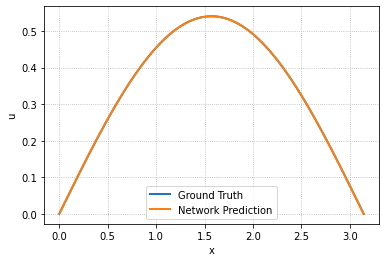

In [14]:
plt.grid(True, which="both", ls=":")
plt.plot(x_test, u_test, label="Ground Truth",lw=2)
plt.plot(x_test, u_test_pred.detach(), label="Network Prediction",lw=2)
plt.xlabel("x")
plt.ylabel("u")
plt.legend()

In [15]:
# Compute the relative L2 error norm (generalization error)
relative_error_test = torch.mean((u_test_pred - u_test)**2)/torch.mean(u_test**2)
#relative_error_test = torch.max(torch.abs(u_test_pred -u_test))/torch.max(torch.abs(u_test))
print("Relative Error Test: ", relative_error_test.detach().numpy()*100, "%")

Relative Error Test:  1.934854765295313e-05 %


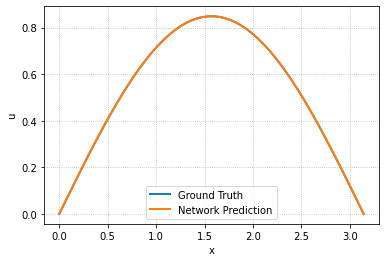

In [16]:
plt.grid(True, which="both", ls=":")
plt.plot(x_test, p_test, label="Ground Truth",lw=2)
plt.plot(x_test, p_test_pred.detach(), label="Network Prediction",lw=2)
plt.xlabel("x")
plt.ylabel("u")
plt.legend()

In [17]:
# Compute the relative L2 error norm (generalization error)
relative_error_test = torch.mean((p_test_pred - p_test)**2)/torch.mean(p_test**2)
#relative_error_test = torch.max(torch.abs(u_test_pred -u_test))/torch.max(torch.abs(u_test))
print("Relative Error Test: ", relative_error_test.detach().numpy()*100, "%")

Relative Error Test:  4.325389113546407e-05 %


In [18]:
# derivative w.r.t t : velocity

x_test = torch.linspace(0, pi, 10000).reshape(-1,1)


t_test_0 = 0.0*torch.ones((10000,1))
test0 = torch.cat([x_test, t_test_0],1)


t_test_1 = 0.25*torch.ones((10000,1))
test1 = torch.cat([x_test, t_test_1],1)



t_test_2 = 0.5*torch.ones((10000,1))
test2 = torch.cat([x_test, t_test_2],1)


t_test_3 = 0.75*torch.ones((10000,1))
test3 = torch.cat([x_test, t_test_3],1)


t_test_4 = torch.ones((10000,1))
test4 = torch.cat([x_test, t_test_4],1)





test0.requires_grad = True
test1.requires_grad = True
test2.requires_grad = True
test3.requires_grad = True
test4.requires_grad = True
# t = 0.0

w_test_pred0 = my_network(test0)
u_test_pred0 = w_test_pred0[:,0].reshape(-1,1)
u_test_pred_0 = w_test_pred0[:,1].reshape(-1,1)

# t = 0.25
w_test_pred1 = my_network(test1)
u_test_pred1 = w_test_pred1[:,0].reshape(-1,1)
u_test_pred_1 = w_test_pred1[:,1].reshape(-1,1)

# t = 0.5
w_test_pred2 = my_network(test2)
u_test_pred2 = w_test_pred2[:,0].reshape(-1,1)
u_test_pred_2 = w_test_pred2[:,1].reshape(-1,1)

# t = 0.75
w_test_pred3 = my_network(test3)
u_test_pred3 = w_test_pred3[:,0].reshape(-1,1)
u_test_pred_3 = w_test_pred3[:,1].reshape(-1,1)

# t = 1
w_test_pred4 = my_network(test4)
u_test_pred4 = w_test_pred4[:,0].reshape(-1,1)
u_test_pred_4 = w_test_pred4[:,1].reshape(-1,1)

In [19]:
def velocity_u(x, t):
    return -torch.sin(x)*torch.sin(t)

In [20]:
# differentiation of 'u' w.r.t 't' (velocity for first beam)
inpu = torch.ones(10000, 1 )
# t = 0             
u_ini_0 = torch.autograd.grad(u_test_pred0, test0, grad_outputs=inpu, create_graph=True)[0]

u_t_0 = u_ini_0[:, 1].reshape(-1, 1)

u_x_0 = u_ini_0[:, 0].reshape(-1, 1)

# t = 0.25
u_ini_1 = torch.autograd.grad(u_test_pred1, test1, grad_outputs=inpu, create_graph=True)[0]

u_t_1 = u_ini_1[:, 1].reshape(-1, 1)
u_x_1 = u_ini_1[:, 0].reshape(-1, 1)

# t = 0.5
u_ini_2 = torch.autograd.grad(u_test_pred2, test2, grad_outputs=inpu, create_graph=True)[0]

u_t_2 = u_ini_2[:, 1].reshape(-1, 1)
u_x_2 = u_ini_2[:, 0].reshape(-1, 1)

# t = 0.75
u_ini_3 = torch.autograd.grad(u_test_pred3,test3, grad_outputs=inpu, create_graph=True)[0]

u_t_3 = u_ini_3[:, 1].reshape(-1, 1)
u_x_3 = u_ini_3[:, 0].reshape(-1, 1)


# t = 1
u_ini_4 = torch.autograd.grad(u_test_pred4, test4, grad_outputs=inpu, create_graph=True)[0]

u_t_4 = u_ini_4[:, 1].reshape(-1, 1)
u_x_4 = u_ini_4[:, 0].reshape(-1, 1)

In [21]:
# exact velocity commute

x_testv = torch.linspace(0, pi, 10).reshape(-1,1)


t_test_0v = 0.0*torch.ones((10,1))
test0v = torch.cat([x_testv, t_test_0v],1)


t_test_1v = 0.25*torch.ones((10,1))
test1v = torch.cat([x_testv, t_test_1v],1)



t_test_2v = 0.5*torch.ones((10,1))
test2v = torch.cat([x_testv, t_test_2v],1)


t_test_3v = 0.75*torch.ones((10,1))
test3v = torch.cat([x_testv, t_test_3v],1)


t_test_4v = torch.ones((10,1))
test4v = torch.cat([x_testv, t_test_4v],1)



v_0 = velocity_u(x_testv, t_test_0v).reshape(-1,1)
v_1 = velocity_u(x_testv, t_test_1v).reshape(-1,1)
v_2 = velocity_u(x_testv, t_test_2v).reshape(-1,1)
v_3 = velocity_u(x_testv, t_test_3v).reshape(-1,1)
v_4 = velocity_u(x_testv, t_test_4v).reshape(-1,1)
v_44 = velocity_u(x_test, t_test_4).reshape(-1,1)

In [22]:
# Compute the relative L2 error norm for second beam velocity(generalization error)
relative_error_test_v_f = torch.mean((u_t_4 - v_44)**2)/torch.mean(v_44**2)
#relative_error_test = torch.max(torch.abs(u_test_pred -u_test))/torch.max(torch.abs(u_test))
print("Relative Error Test_v_first: ", relative_error_test_v_f.detach().numpy()*100, "%")

Relative Error Test_v_first:  0.0019043787688133307 %


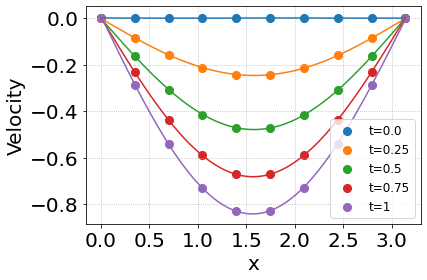

In [23]:
plt.plot(x_test.detach().numpy(), u_t_0.detach().numpy())
plt.scatter(x_testv.detach().numpy(),v_0.detach().numpy(),s = 65,label='t=0.0')
plt.plot(x_test.detach().numpy(), u_t_1.detach().numpy())
plt.scatter(x_testv.detach().numpy(),v_1.detach().numpy(),s = 65,label='t=0.25')
plt.plot(x_test.detach().numpy(), u_t_2.detach().numpy())
plt.scatter(x_testv.detach().numpy(),v_2.detach().numpy(),s = 65,label='t=0.5')
plt.plot(x_test.detach().numpy(), u_t_3.detach().numpy())
plt.scatter(x_testv.detach().numpy(),v_3.detach().numpy(),s = 65,label='t=0.75')
plt.plot(x_test.detach().numpy(), u_t_4.detach().numpy())
plt.scatter(x_testv.detach().numpy(),v_4.detach().numpy(),s = 65,label='t=1')
plt.xlabel('x')
plt.ylabel('velocity')

plt.grid(linestyle='dotted')
plt.legend(loc='lower right', fontsize = 12)
plt.xlabel('x', fontsize = 20)
plt.ylabel('Velocity', fontsize = 20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)


plt.savefig('doublebeam_velocity.png', dpi = 300, bbox_inches = "tight")
#plt.savefig('beam_.pdf')

In [58]:
# Acceleration for first beam
inpu = torch.ones(10000, 1 )
# t = 0             
u_ini_0 = torch.autograd.grad(u_test_pred0, test0, grad_outputs=inpu, create_graph=True)[0]

u_t_0 = u_ini_0[:, 1].reshape(-1, 1)

u_ini_0_t = torch.autograd.grad(u_t_0, test0, grad_outputs=inpu, create_graph=True)[0]

u_tt_0 = u_ini_0_t[:, 1]

# t = 0.25
u_t_1 = u_t_1.reshape(-1, 1)
u_ini_1_t = torch.autograd.grad(u_t_1, test1, grad_outputs=inpu, create_graph=True)[0]



u_tt_1 = u_ini_1_t[:, 1]


# t = 0.5
u_t_2 = u_t_2.reshape(-1, 1)
u_ini_2_t = torch.autograd.grad(u_t_2, test2, grad_outputs=inpu, create_graph=True)[0]

u_tt_2 = u_ini_2_t[:, 1].reshape(-1, 1)


# t = 0.75
u_t_3 = u_t_3.reshape(-1,1)
u_ini_3_t = torch.autograd.grad(u_t_3,test3, grad_outputs=inpu, create_graph=True)[0]

u_tt_3 = u_ini_3_t[:, 1].reshape(-1, 1)


# t = 1

u_t_4 = u_ini_4[:, 1].reshape(-1, 1)

u_ini_4_t = torch.autograd.grad(u_t_4, test4, grad_outputs=inpu, create_graph=True)[0]

u_tt_4 = u_ini_4_t[:, 1].reshape(-1, 1)









In [25]:
def acc_u(x, t):
    return -torch.sin(x)*torch.cos(t)

In [59]:
a_0 = acc_u(x_testv, t_test_0v).reshape(-1,1)
a_1 = acc_u(x_testv, t_test_1v).reshape(-1,1)
a_2 = acc_u(x_testv, t_test_2v).reshape(-1,1)
a_3 = acc_u(x_testv, t_test_3v).reshape(-1,1)
a_4 = acc_u(x_testv, t_test_4v).reshape(-1,1)
a_44 = acc_u(x_test, t_test_4).reshape(-1,1)

In [27]:
# Compute the relative L2 error norm for first beam acceleration(generalization error)
relative_error_test_acc = torch.mean((u_tt_4 - a_44)**2)/torch.mean(a_44**2)
#relative_error_test = torch.max(torch.abs(u_test_pred -u_test))/torch.max(torch.abs(u_test))
print("Relative Error Test_acc_first: ", relative_error_test_acc.detach().numpy()*100, "%")

Relative Error Test_acc_first:  0.190118292812258 %


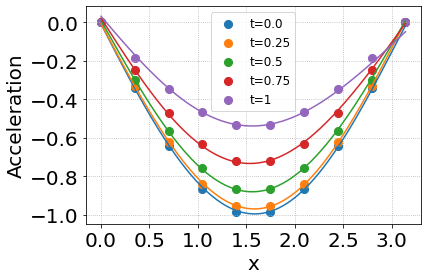

In [28]:
plt.plot(x_test.detach().numpy(), u_tt_0.detach().numpy())
plt.scatter(x_testv.detach().numpy(),a_0.detach().numpy(),s = 65,label='t=0.0')
plt.plot(x_test.detach().numpy(), u_tt_1.detach().numpy())
plt.scatter(x_testv.detach().numpy(),a_1.detach().numpy(),s = 65,label='t=0.25')
plt.plot(x_test.detach().numpy(), u_tt_2.detach().numpy())
plt.scatter(x_testv.detach().numpy(),a_2.detach().numpy(),s = 65,label='t=0.5')
plt.plot(x_test.detach().numpy(), u_tt_3.detach().numpy())
plt.scatter(x_testv.detach().numpy(),a_3.detach().numpy(),s = 65,label='t=0.75')
plt.plot(x_test.detach().numpy(), u_tt_4.detach().numpy())
plt.scatter(x_testv.detach().numpy(),a_4.detach().numpy(),s = 65,label='t=1')
plt.xlabel('x')
plt.ylabel('velocity')

plt.grid(linestyle='dotted')
plt.legend(loc='upper center', fontsize = 12)
plt.xlabel('x', fontsize = 20)
plt.ylabel('Acceleration', fontsize = 20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)


plt.savefig('doublebeam_acceleration.png', dpi = 300, bbox_inches = "tight")
#plt.savefig('beam_.pdf')

In [29]:
# Compute the relative L2 error norm (generalization error)
relative_error_test = torch.mean((p_test_pred - p_test)**2)/torch.mean(p_test**2)
#relative_error_test = torch.max(torch.abs(u_test_pred -u_test))/torch.max(torch.abs(u_test))
print("Relative Error Test: ", relative_error_test.detach().numpy()*100, "%")

Relative Error Test:  4.325389113546407e-05 %


In [30]:
# Bending Moment for first beam
inpu = torch.ones(10000, 1 )
# t = 0             


u_ini_0_x = torch.autograd.grad(u_x_0, test0, grad_outputs=inpu, create_graph=True)[0]

u_xx_0 = u_ini_0_x[:, 0]

# t = 0.25

u_ini_1_x = torch.autograd.grad(u_x_1, test1, grad_outputs=inpu, create_graph=True)[0]



u_xx_1 = u_ini_1_x[:, 0]



u_ini_2_x = torch.autograd.grad(u_x_2, test2, grad_outputs=inpu, create_graph=True)[0]

u_xx_2 = u_ini_2_x[:, 0].reshape(-1, 1)


# t = 0.75

u_ini_3_x = torch.autograd.grad(u_x_3,test3, grad_outputs=inpu, create_graph=True)[0]

u_xx_3 = u_ini_3_x[:, 0].reshape(-1, 1)


# t = 1


u_ini_4_x = torch.autograd.grad(u_x_4, test4, grad_outputs=inpu, create_graph=True)[0]

u_xx_4 = u_ini_4_x[:, 0].reshape(-1, 1)



In [31]:
def bend_u(x, t):
    return -torch.sin(x)*torch.cos(t)



b_0 = bend_u(x_testv, t_test_0v).reshape(-1,1)
b_1 = bend_u(x_testv, t_test_1v).reshape(-1,1)
b_2 = bend_u(x_testv, t_test_2v).reshape(-1,1)
b_3 = bend_u(x_testv, t_test_3v).reshape(-1,1)
b_4 = bend_u(x_testv, t_test_4v).reshape(-1,1)

b_44 = bend_u(x_test, t_test_4).reshape(-1,1)

In [32]:
# Compute the relative L2 error norm for first beam bending moment(generalization error)
relative_error_test_bm = torch.mean((u_xx_4 - b_44)**2)/torch.mean(b_44**2)
#relative_error_test = torch.max(torch.abs(u_test_pred -u_test))/torch.max(torch.abs(u_test))
print("Relative Error Test_bm_first: ", relative_error_test_bm.detach().numpy()*100, "%")

Relative Error Test_bm_first:  0.0009611214409233071 %


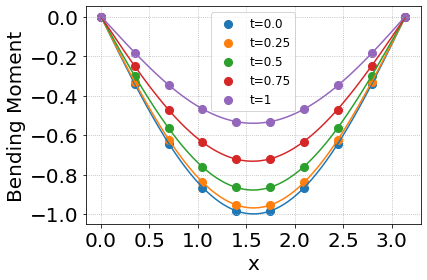

In [33]:
plt.plot(x_test.detach().numpy(), u_xx_0.detach().numpy())
plt.scatter(x_testv.detach().numpy(),b_0.detach().numpy(),s = 65,label='t=0.0')
plt.plot(x_test.detach().numpy(), u_xx_1.detach().numpy())
plt.scatter(x_testv.detach().numpy(),b_1.detach().numpy(),s = 65,label='t=0.25')
plt.plot(x_test.detach().numpy(), u_xx_2.detach().numpy())
plt.scatter(x_testv.detach().numpy(),b_2.detach().numpy(),s = 65,label='t=0.5')
plt.plot(x_test.detach().numpy(), u_xx_3.detach().numpy())
plt.scatter(x_testv.detach().numpy(),b_3.detach().numpy(),s = 65,label='t=0.75')
plt.plot(x_test.detach().numpy(), u_xx_4.detach().numpy())
plt.scatter(x_testv.detach().numpy(),b_4.detach().numpy(),s = 65,label='t=1')
plt.xlabel('x')
plt.ylabel('velocity')

plt.grid(linestyle='dotted')
plt.legend(loc='upper center', fontsize = 12)
plt.xlabel('x', fontsize = 20)
plt.ylabel('Bending Moment', fontsize = 20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)


plt.savefig('First_beam_bending_moment.png', dpi = 300, bbox_inches = "tight")
#plt.savefig('beam_.pdf')

In [34]:
# velocity for Second beam
inpu = torch.ones(10000, 1 )
# t = 0             
p_ini_0 = torch.autograd.grad(u_test_pred_0, test0, grad_outputs=inpu, create_graph=True)[0]

p_t_0 = p_ini_0[:, 1].reshape(-1, 1)

p_x_0 = p_ini_0[:, 0].reshape(-1, 1)

# t = 0.25
p_ini_1 = torch.autograd.grad(u_test_pred_1, test1, grad_outputs=inpu, create_graph=True)[0]

p_t_1 = p_ini_1[:, 1].reshape(-1, 1)
p_x_1 = p_ini_1[:, 0].reshape(-1, 1)

# t = 0.5
p_ini_2 = torch.autograd.grad(u_test_pred_2, test2, grad_outputs=inpu, create_graph=True)[0]

p_t_2 = p_ini_2[:, 1].reshape(-1, 1)
p_x_2 = p_ini_2[:, 0].reshape(-1, 1)

# t = 0.75
p_ini_3 = torch.autograd.grad(u_test_pred_3,test3, grad_outputs=inpu, create_graph=True)[0]

p_t_3 = p_ini_3[:, 1].reshape(-1, 1)
p_x_3 = p_ini_3[:, 0].reshape(-1, 1)


# t = 1
p_ini_4 = torch.autograd.grad(u_test_pred_4, test4, grad_outputs=inpu, create_graph=True)[0]

p_t_4 = p_ini_4[:, 1].reshape(-1, 1)
p_x_4 = p_ini_4[:, 0].reshape(-1, 1)

In [35]:
def velocity_p(x, t):
    return -pi/2*torch.sin(x)*torch.sin(t)

In [36]:
p_0 = velocity_p(x_testv, t_test_0v).reshape(-1,1)
p_1 = velocity_p(x_testv, t_test_1v).reshape(-1,1)
p_2 = velocity_p(x_testv, t_test_2v).reshape(-1,1)
p_3 = velocity_p(x_testv, t_test_3v).reshape(-1,1)
p_4 = velocity_p(x_testv, t_test_4v).reshape(-1,1)
p_44 = velocity_p(x_test, t_test_4).reshape(-1,1)
print(p_t_4.shape)
print(p_44.shape)

torch.Size([10000, 1])
torch.Size([10000, 1])


In [37]:
# Compute the relative L2 error norm for second beam velocity(generalization error)
relative_error_test_v = torch.mean((p_t_4 - p_44)**2)/torch.mean(p_44**2)
#relative_error_test = torch.max(torch.abs(u_test_pred -u_test))/torch.max(torch.abs(u_test))
print("Relative Error Test_v_second: ", relative_error_test_v.detach().numpy()*100, "%")

Relative Error Test_v_second:  0.0020161929569439963 %


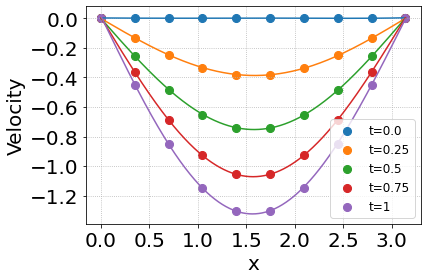

In [38]:
plt.plot(x_test.detach().numpy(),p_t_0.detach().numpy())
plt.scatter(x_testv.detach().numpy(),p_0.detach().numpy(),s = 65,label='t=0.0')
plt.plot(x_test.detach().numpy(), p_t_1.detach().numpy())
plt.scatter(x_testv.detach().numpy(),p_1.detach().numpy(),s = 65,label='t=0.25')
plt.plot(x_test.detach().numpy(), p_t_2.detach().numpy())
plt.scatter(x_testv.detach().numpy(),p_2.detach().numpy(),s = 65,label='t=0.5')
plt.plot(x_test.detach().numpy(), p_t_3.detach().numpy())
plt.scatter(x_testv.detach().numpy(),p_3.detach().numpy(),s = 65,label='t=0.75')
plt.plot(x_test.detach().numpy(),p_t_4.detach().numpy())
plt.scatter(x_testv.detach().numpy(),p_4.detach().numpy(),s = 65,label='t=1')
plt.xlabel('x')
plt.ylabel('velocity')

plt.grid(linestyle='dotted')
plt.legend(loc='lower right', fontsize = 12)
plt.xlabel('x', fontsize = 20)
plt.ylabel('Velocity', fontsize = 20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)


plt.savefig('other_beam_velocity.png', dpi = 300, bbox_inches = "tight")
#plt.savefig('beam_.pdf')

In [39]:
# Acceleration for second beam
inpu = torch.ones(10000, 1 )
# t = 0             

p_ini_0_t = torch.autograd.grad(p_t_0, test0, grad_outputs=inpu, create_graph=True)[0]

p_tt_0 = p_ini_0_t[:, 1]

# t = 0.25

p_ini_1_t = torch.autograd.grad(p_t_1, test1, grad_outputs=inpu, create_graph=True)[0]



p_tt_1 = p_ini_1_t[:, 1]


# t = 0.5
p_t_2 = p_t_2.reshape(-1, 1)
p_ini_2_t = torch.autograd.grad(p_t_2, test2, grad_outputs=inpu, create_graph=True)[0]

p_tt_2 = p_ini_2_t[:, 1].reshape(-1, 1)


# t = 0.75
p_t_3 = p_t_3.reshape(-1,1)
p_ini_3_t = torch.autograd.grad(p_t_3,test3, grad_outputs=inpu, create_graph=True)[0]
p_tt_3 = p_ini_3_t[:, 1].reshape(-1, 1)


# t = 1
p_t_4 = p_ini_4[:, 1].reshape(-1, 1)

p_ini_4_t = torch.autograd.grad(p_t_4, test4, grad_outputs=inpu, create_graph=True)[0]

p_tt_4 = p_ini_4_t[:, 1].reshape(-1, 1)




In [40]:
def acc_p(x, t):
    return -pi/2*torch.sin(x)*torch.cos(t)

In [41]:
a_p0 = acc_p(x_testv, t_test_0v).reshape(-1,1)
a_p1 = acc_p(x_testv, t_test_1v).reshape(-1,1)
a_p2 = acc_p(x_testv, t_test_2v).reshape(-1,1)
a_p3 = acc_p(x_testv, t_test_3v).reshape(-1,1)
a_p4 = acc_p(x_testv, t_test_4v).reshape(-1,1)
a_p44 = acc_p(x_test, t_test_4).reshape(-1,1)

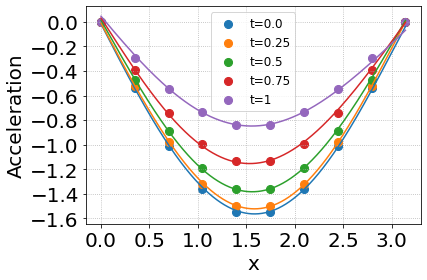

In [42]:
plt.plot(x_test.detach().numpy(), p_tt_0.detach().numpy())
plt.scatter(x_testv.detach().numpy(),a_p0.detach().numpy(),s = 65,label='t=0.0')
plt.plot(x_test.detach().numpy(), p_tt_1.detach().numpy())
plt.scatter(x_testv.detach().numpy(),a_p1.detach().numpy(),s = 65,label='t=0.25')
plt.plot(x_test.detach().numpy(), p_tt_2.detach().numpy())
plt.scatter(x_testv.detach().numpy(),a_p2.detach().numpy(),s = 65,label='t=0.5')
plt.plot(x_test.detach().numpy(), p_tt_3.detach().numpy())
plt.scatter(x_testv.detach().numpy(),a_p3.detach().numpy(),s = 65,label='t=0.75')
plt.plot(x_test.detach().numpy(), p_tt_4.detach().numpy())
plt.scatter(x_testv.detach().numpy(),a_p4.detach().numpy(),s = 65,label='t=1')
plt.xlabel('x')
plt.ylabel('velocity')

plt.grid(linestyle='dotted')
plt.legend(loc='upper center', fontsize = 12)
#blue_line = mlines.Line2D([], [], color='blue', marker='*',
                          #markersize=15, label='Blue stars')
plt.xlabel('x', fontsize = 20)
plt.ylabel('Acceleration', fontsize = 20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)


plt.savefig('other_beam_acceleration.png', dpi = 300, bbox_inches = "tight")
#plt.savefig('beam_.pdf')

In [43]:
# Compute the relative L2 error norm for second beam acceleration(generalization error)
relative_error_test_a = torch.mean((p_tt_4 - a_p44)**2)/torch.mean(a_p44**2)
#relative_error_test = torch.max(torch.abs(u_test_pred -u_test))/torch.max(torch.abs(u_test))
print("Relative Error Test_a_second: ", relative_error_test_a.detach().numpy()*100, "%")

Relative Error Test_a_second:  0.1444249413907528 %


In [44]:
# Second beam bending Moment
inpu = torch.ones(10000, 1 )
# t = 0             


p_ini_0_x = torch.autograd.grad(p_x_0, test0, grad_outputs=inpu, create_graph=True)[0]

p_xx_0 = p_ini_0_x[:, 0]

# t = 0.25
p_ini_1_x = torch.autograd.grad(p_x_1, test1, grad_outputs=inpu, create_graph=True)[0]



p_xx_1 = p_ini_1_x[:, 0]



p_ini_2_x = torch.autograd.grad(p_x_2, test2, grad_outputs=inpu, create_graph=True)[0]

p_xx_2 = p_ini_2_x[:, 0].reshape(-1, 1)


# t = 0.75

p_ini_3_x = torch.autograd.grad(p_x_3,test3, grad_outputs=inpu, create_graph=True)[0]

p_xx_3 = p_ini_3_x[:, 0].reshape(-1, 1)


# t = 1


p_ini_4_x = torch.autograd.grad(p_x_4, test4, grad_outputs=inpu, create_graph=True)[0]

p_xx_4 = p_ini_4_x[:, 0].reshape(-1, 1)



In [45]:
def bend_u_p(x, t):
    return -pi/2*torch.sin(x)*torch.cos(t)



p_b_0 = bend_u_p(x_testv, t_test_0v).reshape(-1,1)
p_b_1 = bend_u_p(x_testv, t_test_1v).reshape(-1,1)
p_b_2 = bend_u_p(x_testv, t_test_2v).reshape(-1,1)
p_b_3 = bend_u_p(x_testv, t_test_3v).reshape(-1,1)
p_b_4 = bend_u_p(x_testv, t_test_4v).reshape(-1,1)
p_b_44 = bend_u_p(x_test, t_test_4).reshape(-1,1)


In [46]:
# Compute the relative L2 error norm for second beam velocity(generalization error)
relative_error_test_b = torch.mean((p_xx_4 - p_b_44)**2)/torch.mean(p_b_44**2)
#relative_error_test = torch.max(torch.abs(u_test_pred -u_test))/torch.max(torch.abs(u_test))
print("Relative Error Test_b_second: ", relative_error_test_b.detach().numpy()*100, "%")

Relative Error Test_b_second:  0.0006550686975970166 %


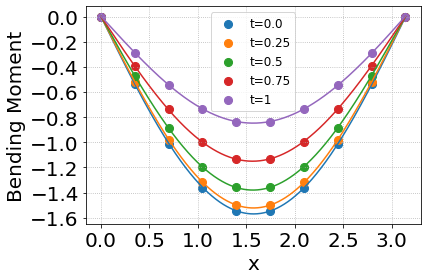

In [47]:
plt.plot(x_test.detach().numpy(), p_xx_0.detach().numpy())
plt.scatter(x_testv.detach().numpy(),p_b_0.detach().numpy(),s = 65,label='t=0.0')
plt.plot(x_test.detach().numpy(), p_xx_1.detach().numpy())
plt.scatter(x_testv.detach().numpy(),p_b_1.detach().numpy(),s = 65,label='t=0.25')
plt.plot(x_test.detach().numpy(), p_xx_2.detach().numpy())
plt.scatter(x_testv.detach().numpy(),p_b_2.detach().numpy(),s = 65,label='t=0.5')
plt.plot(x_test.detach().numpy(), p_xx_3.detach().numpy())
plt.scatter(x_testv.detach().numpy(),p_b_3.detach().numpy(),s = 65,label='t=0.75')
plt.plot(x_test.detach().numpy(), p_xx_4.detach().numpy())
plt.scatter(x_testv.detach().numpy(),p_b_4.detach().numpy(),s = 65,label='t=1')
plt.xlabel('x')
plt.ylabel('velocity')

plt.grid(linestyle='dotted')
plt.legend(loc='upper center', fontsize = 12)
plt.xlabel('x', fontsize = 20)
plt.ylabel('Bending Moment', fontsize = 20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)


plt.savefig('Second_beam_bending_moment.png', dpi = 300, bbox_inches = "tight")
#plt.savefig('beam_.pdf')

In [48]:
# for contour plots

In [49]:
x1 = pi*torch.rand(1000000)
t1 = torch.rand(1000000)
x1 = x1.reshape(-1, 1)
t1 = t1.reshape(-1, 1)
s = torch.cat([x1, t1], 1)

In [50]:
u_pred = my_network(s)

In [51]:
u = u_pred[:, 0].reshape(-1,)
p = u_pred[:, 1].reshape(-1,)


In [52]:
u = u.detach().numpy()
p = p.detach().numpy()

In [53]:
e_u = exact_solution_u(x1, t1).reshape(-1,)
e_p = exact_solution_p(x1, t1).reshape(-1,)

In [54]:
e_u = e_u.detach().numpy()
e_p = e_p.detach().numpy()

In [55]:
r_u = np.abs(e_u - u)
r_p = np.abs(e_p - p)
x1 = x1.reshape(-1,)
t1 = t1.reshape(-1,)

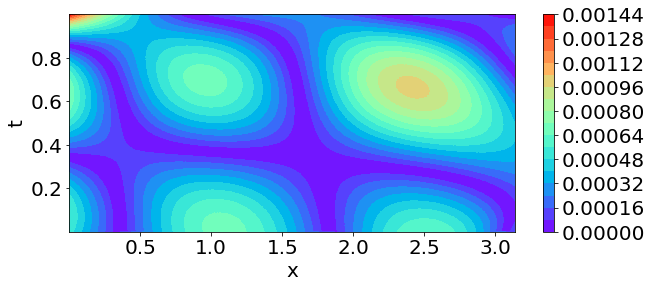

In [56]:
plt.rcParams['figure.figsize'] = [10, 4]
CS = plt.tricontourf(x1, t1, r_p, 20, cmap='rainbow')


cbar = plt.colorbar(CS)
for t in cbar.ax.get_yticklabels():
     t.set_fontsize(20)


plt.xlabel('x', fontsize=20)
plt.ylabel('t', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.savefig('relative_error_double_beam_system_r_p_third.png', dpi = 300, bbox_inches = "tight")
plt.show()


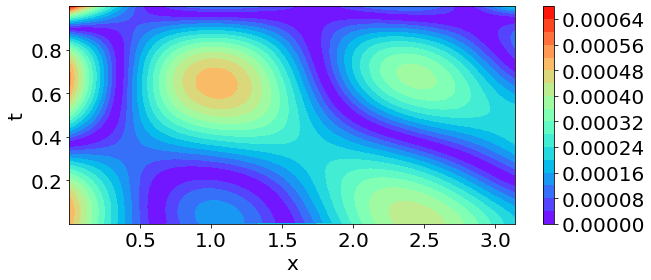

In [57]:
CS = plt.tricontourf(x1, t1, r_u, 20, cmap='rainbow')


cbar = plt.colorbar(CS)
for t in cbar.ax.get_yticklabels():
     t.set_fontsize(20)


plt.xlabel('x', fontsize=20)
plt.ylabel('t', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.savefig('relative_error_double_beam_r_u_third.png', dpi = 300, bbox_inches = "tight")